In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

In [2]:
# Load the dataset
df = pd.read_csv('E:\pre_master\ComputationalIntelligence\DeepLearning\Assignment5\data\IMDB Dataset.csv')

In [3]:
# Data Preprocessing
df = df.dropna()    #used to remove any rows or columns from a Pandas DataFrame that contain missing or NaN values
df = df.reset_index(drop=True) #re-indexing the data


In [4]:
# Download the stopwords corpus if not already downloaded
nltk.download('stopwords')

# Get the set of English stopwords
stop_words = set(stopwords.words('english'))

ps = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Fayrouz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
#pre processing method that clean and normalize the text
def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text) # replace all non-alphabetic characters in a string text with a space.
    text = text.lower().split() #converts a string text to lowercase and splits it into a list of words.
    text = [ps.stem(word) for word in text if not word in stop_words] # remove stop words
    text = ' '.join(text)   #joins a list of strings text into a single string with space character ' ' as a separator between each element
    return text

df['review'] = df['review'].apply(preprocess_text)

In [6]:
#creates a Tokenizer object with a vocabulary size of 5000 and space character ' ' as the word separator.
tokenizer = Tokenizer(num_words=5000, split=' ')

#fits the Tokenizer object to a corpus of text
tokenizer.fit_on_texts(df['review'].values)

#converts a corpus of text into a sequence of integers
X = tokenizer.texts_to_sequences(df['review'].values)

#pads the sequences of integers with zeros to ensure that all sequences have the same length.
X = pad_sequences(X)
#convert a categorical variable into a one-hot encoded matrix of binary values.
Y = pd.get_dummies(df['sentiment']).values

In [7]:
#split the data into 80% train and 20% test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [8]:
# Word Embedding 
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('E:/pre_master/ComputationalIntelligence/DeepLearning/Assignment5/glove.6B.100d.txt', encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [9]:
#creates an empty numpy array of shape (num_words, embedding_dim) to store the word embeddings.
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, embedding_dim))

#get vector of each word from embbeding dictionary
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Model Creation
model = Sequential()
embedding_layer = Embedding(len(tokenizer.word_index)+1, embedding_dim, weights=[embedding_matrix], input_length=X.shape[1], trainable=False)
model.add(embedding_layer)
model.add(LSTM(100))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1132, 100)         6901800   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 6,982,402
Trainable params: 80,602
Non-trainable params: 6,901,800
_________________________________________________________________
None


In [10]:
#trian the model on 100 epoch with  batch size 100 -> we get 400 batch
history=model.fit(X_train, Y_train, epochs=10, batch_size=100, validation_data=(X_test, Y_test))

Epoch 1/10
400/400 [==============================] - 1766s 4s/step - loss: 0.5280 - accuracy: 0.7379 - val_loss: 0.4736 - val_accuracy: 0.7812
Epoch 2/10
400/400 [==============================] - 1798s 4s/step - loss: 0.4505 - accuracy: 0.7941 - val_loss: 0.4197 - val_accuracy: 0.8112
Epoch 3/10
400/400 [==============================] - 1847s 5s/step - loss: 0.3880 - accuracy: 0.8281 - val_loss: 0.3853 - val_accuracy: 0.8276
Epoch 4/10
400/400 [==============================] - 1788s 4s/step - loss: 0.3636 - accuracy: 0.8425 - val_loss: 0.3616 - val_accuracy: 0.8370
Epoch 5/10
400/400 [==============================] - 1883s 5s/step - loss: 0.3340 - accuracy: 0.8578 - val_loss: 0.3414 - val_accuracy: 0.8520
Epoch 6/10
400/400 [==============================] - 1925s 5s/step - loss: 0.3195 - accuracy: 0.8651 - val_loss: 0.3575 - val_accuracy: 0.8429
Epoch 7/10
400/400 [==============================] - 1959s 5s/step - loss: 0.2964 - accuracy: 0.8748 - val_loss: 0.3334 - val_accuracy:

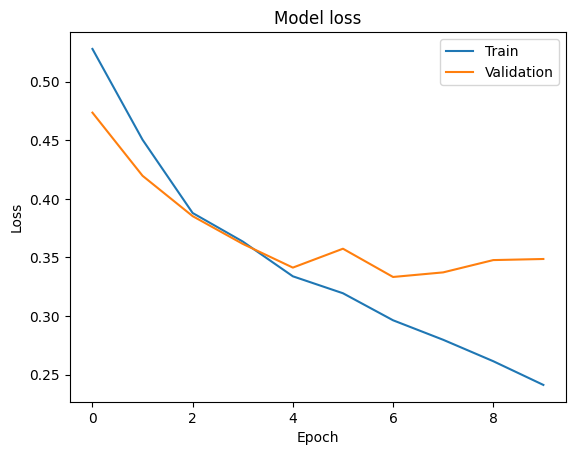

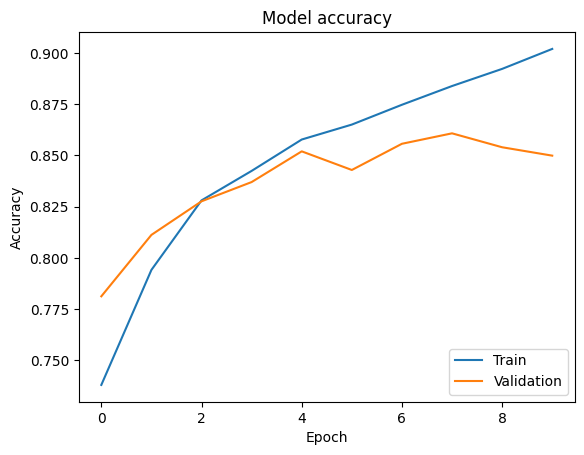

In [11]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [12]:
# calculate the model accuracy on test data set
loss, accuracy = model.evaluate(X_test, Y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

313/313 [==============================] - 175s 556ms/step - loss: 0.3487 - accuracy: 0.8499
Test loss: 0.3487250506877899
Test accuracy: 0.8499000072479248


In [13]:
#Save the model current state
model.save('my_model.h5')

In [14]:
# Load the model
from keras.models import load_model
loaded_model = load_model('my_model.h5')

In [15]:
# recalculate the saved model accuracy on test data set to make sure that its good saved
loss, accuracy = loaded_model.evaluate(X_test, Y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

313/313 [==============================] - 303s 964ms/step - loss: 0.3487 - accuracy: 0.8499
Test loss: 0.3487250506877899
Test accuracy: 0.8499000072479248


In [16]:
#Inferance
def predict_text(text):
        word_seq = np.array([preprocess_text(word)] for word in text.split())
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  pad_sequences(word_seq)
        inputs = pad.to('cpu')
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        model.pre
        output, h = model(inputs, h)
        return(output.item())

In [34]:
# Make predictions on new input data
new_data = [df['review'][1]]
preprocessed_data = [preprocess_text(text) for text in new_data]
X_new = tokenizer.texts_to_sequences(preprocessed_data)
X_new = pad_sequences(X_new, maxlen=1132)
Y_pred = model.predict(X_new)

# Print the predicted values
for i in range(len(new_data)):
    max_index_1 = np.argmax(Y_pred[i])
    predected_class= 'Positive' if max_index_1==0 else 'Negative'
    actual_class=df['sentiment'][0]
    print(f'Input: {new_data[i]}')
    print(f'Predicted value: {Y_pred[i]}')
    print(f'Predicted class with new model: {predected_class}')
    print(f'Actual class: {actual_class}')

1/1 [==============================] - 0s 215ms/step
Input: wonder littl product br br film techniqu unassum old time bbc fashion give comfort sometim discomfort sens realism entir piec br br actor extrem well chosen michael sheen got polari voic pat truli see seamless edit guid refer william diari entri well worth watch terrificli written perform piec master product one great master comedi life br br realism realli come home littl thing fantasi guard rather use tradit dream techniqu remain solid disappear play knowledg sens particularli scene concern orton halliwel set particularli flat halliwel mural decor everi surfac terribl well done
Predicted value: [0.00894478 0.99105513]
Predicted class with new model: Negative
Actual class: positive


In [22]:
#Define a function to compute the confusion matrix for 5 classes
from sklearn import metrics
import seaborn as sns

def compute_confusion(actual, predicted):
    confm = metrics.confusion_matrix(actual, predicted)

    cm_df = pd.DataFrame(confm,
                         index = ['positive','negative'], 
                         columns = ['positive','negative'])

    #Plotting the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()

In [35]:
#generate class prediction according to the output probabilities
yhat_probs=model.predict(X_test)


313/313 [==============================] - 165s 525ms/step


In [25]:
yhat_classes=[]
for elemet in yhat_probs:
    maximun=np.max(elemet)
    ihat=[]
    for j in range(0, 2):
        if(elemet[j]==maximun):
            ihat.append(1)
        else:
            ihat.append(0)
    yhat_classes.append(ihat)
yhat_classes = np.array(yhat_classes)

In [27]:
yhat_classes_index= np.where(yhat_classes == 1)[1]
y_test_actual=np.where(Y_test == 1)[1]

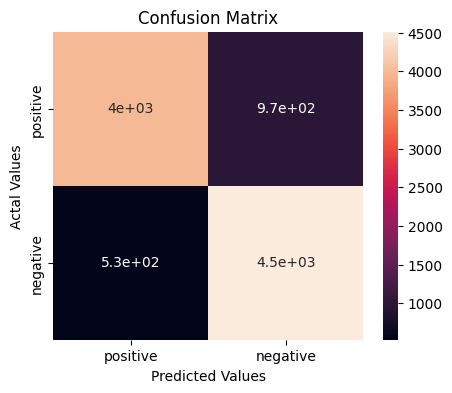

In [28]:
compute_confusion(y_test_actual,yhat_classes_index)

In [30]:
#Define a function to calculate the accuracy, precision, recall , f1 score values
def get_measuring_valves(actual_data, predected_data):
# accuracy: (tp + tn) / (p + n)
    accuracy = metrics.accuracy_score(actual_data, predected_data)
    
#precision tp / (tp + fp)
    precision = metrics.precision_score(actual_data, predected_data, average='weighted')
    
#recall: tp / (tp + fn)
    recall = metrics.recall_score(actual_data, predected_data, average='macro')
    
# f1: 2 tp / (2 tp + fp + fn)
    f1 = metrics.f1_score(actual_data, predected_data, average='weighted')
    
    return accuracy,precision,recall ,f1

In [33]:
acc,  preci, recall,f1= get_measuring_valves(y_test_actual, yhat_classes_index)
print('Accuracy: %f' % acc)
print('Precision: %f' % preci)
print('Recall: %f' % recall)
print('F1 score: %f' % f1)

Accuracy: 0.849900
Precision: 0.852618
Recall: 0.849542
F1 score: 0.849547
